## Wan Yi Lam (S4060745)

In [1]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import re 

# Reply Graph - Youtube - Maleficent

In [2]:
sFileName = 'youtube_maleficent_reply_graph.graphml'

# Initialize the directed graph
replyGraph = nx.DiGraph()

# Initialize dictionary to map full IDs to authors for submissions
dSubCommentId = {}

In [3]:
def create_safe_id(input_string):
    """
    Creates a safer string for use as an ID by removing special characters and replacing whitespace with underscores.
    """
    if not isinstance(input_string, str):
        input_string = str(input_string) 
    # Remove characters that are not alphanumeric, underscore, or hyphen
    s = re.sub(r'[^\w\s-]', '', input_string)
    # Replace whitespace sequences with a single underscore
    s = re.sub(r'\s+', '_', s)
    # Remove leading/trailing underscores that might result
    return s.strip('_')

def flatten_comments(comments_list_from_json, parent_graph_id_for_this_level):
    """
    Recursively flattens a list of comments and their replies.
    
    @param comments_list_from_json: The list of comment objects 
    @param parent_graph_id_for_this_level: The graph ID of the parent 
    
    Returns:
        A list of flat comment dictionaries, each with "full_id", "author", and "parent_id" 
    """
    all_flat_comments = []

    def _recursive_flatten(current_level_json_comments, current_parent_graph_id):
        if not current_level_json_comments: 
            return
        
        for comment_data_json in current_level_json_comments:
            comment_original_id = comment_data_json["id"]
            comment_graph_id = "c_" + comment_original_id 
            
            author_name = comment_data_json.get("author")
            if not author_name: # Handles None or empty string for author
                author_name = "UnknownCommenter"
            
            all_flat_comments.append({
                "full_id": comment_graph_id, 
                "author": author_name,
                "parent_id": current_parent_graph_id 
            })

            # If comment has replies, recurse
            if "replies" in comment_data_json and comment_data_json["replies"]:
                # The parent for these replies is the current comment's graph ID
                _recursive_flatten(comment_data_json["replies"], comment_graph_id) 

    # Initial call for the passed list of comments
    _recursive_flatten(comments_list_from_json, parent_graph_id_for_this_level)
        
    return all_flat_comments

 
def process_video(video_data_item):
    """
    Processes a single video dictionary, extracts info, and builds the reply graph.
    """
    try:
        video_title = video_data_item.get('Title')
        if not video_title:
            # Attempt to create a fallback ID if title is missing, or skip
            video_title = "UntitledVideo_" + create_safe_id(video_data_item.get('Thumbnail', 'NoThumbnail'))

        uploader_name = video_data_item.get('Uploader')
        if not uploader_name: # Handles None or empty string for uploader
            uploader_name = "UnknownUploader"
        
        # Create a graph-specific ID for the video "submission"
        submission_base_id = create_safe_id(video_title)
        submission_full_graph_id = "v_" + submission_base_id # "v_" prefix for video submissions

        print(f"Processing video: '{video_title}' (Graph ID: {submission_full_graph_id}) by Uploader: {uploader_name}")

        # Add the uploader (as submission author) to the graph
        if uploader_name in replyGraph:
            replyGraph.nodes[uploader_name]['subNum'] += 1
        else:
            # For a new uploader, subNum is 1 (this video)
            replyGraph.add_node(uploader_name, subNum=1)

        # Initialize the ID-to-author mapping for this video.
        dSubCommentId[submission_full_graph_id] = {submission_full_graph_id: uploader_name}

        # Flatten comments if they exist
        flat_comments_list = []
        if "Comments" in video_data_item and video_data_item["Comments"]:
            # The parent for top-level comments is the video submission's graph ID
            flat_comments_list = flatten_comments(video_data_item["Comments"], submission_full_graph_id)
        else:
            print(f"  No comments found for video '{video_title}'.")

        # Populate the ID-to-author map for all comments of this video
        for comment_dict in flat_comments_list:
            dSubCommentId[submission_full_graph_id][comment_dict["full_id"]] = comment_dict["author"]

        # Construct the reply graph edges based on the flattened comments
        for comment_dict in flat_comments_list:
            commenting_author = comment_dict["author"]
            parent_item_graph_id = comment_dict["parent_id"] # This is the graph ID of the parent (video or another comment)

            # Ensure the commenting author node exists in the graph
            if commenting_author not in replyGraph:
                replyGraph.add_node(commenting_author, subNum=0) 

            # Retrieve the parent's author from the map for this video
            if parent_item_graph_id in dSubCommentId[submission_full_graph_id]:
                parent_author_name = dSubCommentId[submission_full_graph_id][parent_item_graph_id]
                
                # Parent author should already be in the graph (either as uploader or a previous commenter)
                # Ensure node exists just in case
                if parent_author_name not in replyGraph:
                    replyGraph.add_node(parent_author_name, subNum=0) 
                
                # Add or update the reply edge (commenting_author -> parent_author_name)
                if replyGraph.has_edge(commenting_author, parent_author_name):
                    replyGraph[commenting_author][parent_author_name]['replyNum'] += 1
                else:
                    replyGraph.add_edge(commenting_author, parent_author_name, replyNum=1)
            else:
                # This indicates a broken parent link or an issue in dSubCommentId population
                print(f"  Warning: Parent ID '{parent_item_graph_id}' for comment '{comment_dict['full_id']}' "
                      f"not found in ID map for video '{submission_full_graph_id}'. Skipping edge construction.")

    except KeyError as e:
        title_for_error = video_data_item.get('Title', 'N/A') if isinstance(video_data_item, dict) else "UnknownVideo"
        print(f"Error processing video entry (Title: {title_for_error}): Missing key {e}. "
              f"Available keys: {list(video_data_item.keys()) if isinstance(video_data_item, dict) else 'Not a dict'}")
    except Exception as e:
        title_for_error = video_data_item.get('Title', 'N/A') if isinstance(video_data_item, dict) else "UnknownVideo"
        print(f"An unexpected error occurred while processing video (Title: {title_for_error}): {e}")


# Main Script Execution 
if __name__ == "__main__":
    file_path = 'youtube_maleficent.json'
    with open(file_path, 'r', encoding='utf-8') as f: 
        main_youtube_data = json.load(f)

    # Process the loaded data based on its structure
    if isinstance(main_youtube_data, list):
        print(f"Found a list of {len(main_youtube_data)} video entries. Processing...")
        for video_data_entry in main_youtube_data:
            if isinstance(video_data_entry, dict):
                process_video(video_data_entry)
            else:
                print(f"Warning: Encountered an item in the main list that is not a dictionary (expected video data). Type: {type(video_data_entry)}. Skipping.")
    elif isinstance(main_youtube_data, dict): 
        print("Found a single video entry in the JSON file. Processing...")
        process_video(main_youtube_data)
    else:
        print(f"Error: Unexpected JSON structure in '{file_path}'. Expected a list of video objects or a single video object. Got type: {type(main_youtube_data)}")
        exit()


Found a list of 3 video entries. Processing...
Processing video: 'Disney's Maleficent - "Dream" Trailer' (Graph ID: v_Disneys_Maleficent_-_Dream_Trailer) by Uploader: Disney
Processing video: 'Maleficent's Curse Scene (Maleficent)' (Graph ID: v_Maleficents_Curse_Scene_Maleficent) by Uploader: Lord Phoenix
Processing video: 'Maleficent movie review' (Graph ID: v_Maleficent_movie_review) by Uploader: Jeremy Jahns


### Reference: Codes below are from COSC2671 Social Media and Network Analytics Workshop 8 & 9, created by Jeffrey Chan, RMIT University, 2023.

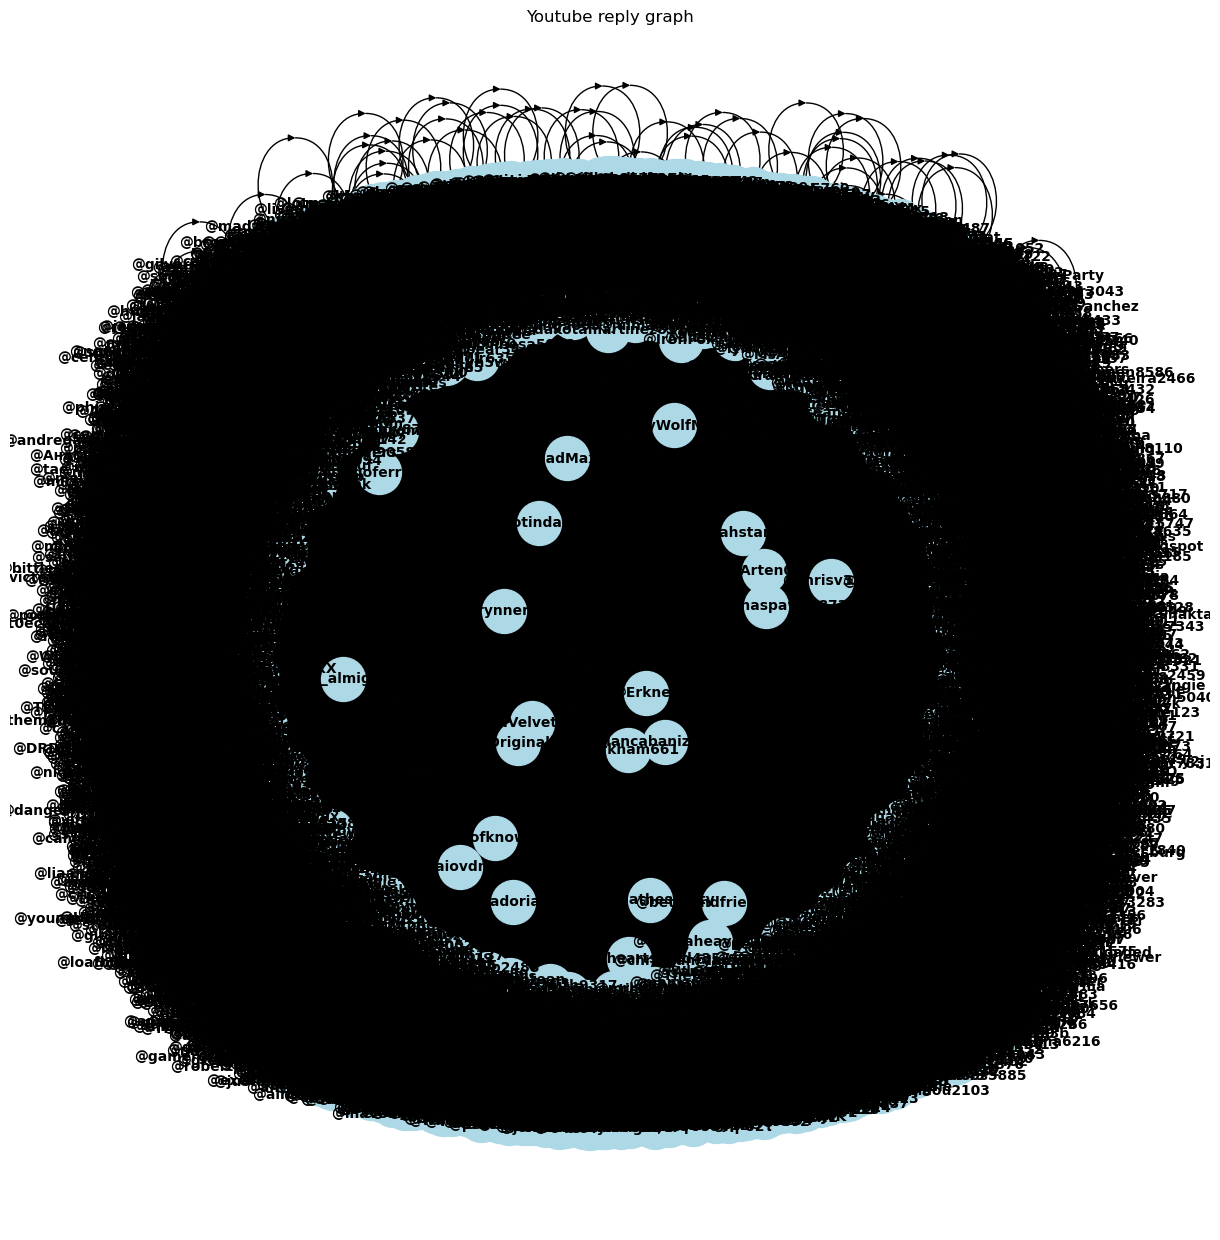

Number of nodes:  10378
Number of edges:  11545


In [11]:
nx.readwrite.write_graphml(replyGraph, sFileName)   
# read the graph from the file
replyGraph = nx.readwrite.read_graphml(sFileName)
# draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(replyGraph, k=0.5, iterations=20)
nx.draw(replyGraph, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title('Youtube reply graph')
plt.show()
# print the number of nodes and edges
print("Number of nodes: ", replyGraph.number_of_nodes())
print("Number of edges: ", replyGraph.number_of_edges())

# SNA Measures - Youtube - Maleficent

In [12]:
sFileName = 'youtube_maleficent_reply_graph.graphml'

# read it back in to demonstrate it works
replyGraph = nx.readwrite.read_graphml(sFileName)

# Degree centrality 
lDegCentrality = nx.degree_centrality(replyGraph)

# eigenvetor and katz centrality
lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph)

# Katz centrality
lKatzCentrality = nx.katz_centrality(replyGraph)

# betweenness centrality
lBetweennessCentrality = nx.betweenness_centrality(replyGraph)

# closeness centrality
lClosenessCentrality = nx.closeness_centrality(replyGraph)
# print the results
print("\n--- Centrality Measures ---")
print("Degree Centrality: ", lDegCentrality)
print("Eigenvector Centrality: ", lEigenVectorCentrality)
print("Katz Centrality: ", lKatzCentrality)

print("Betweenness Centrality: ", lBetweennessCentrality)
print("Closeness Centrality: ", lClosenessCentrality)




--- Centrality Measures ---
Degree Centrality:  {'Disney': 0.46130866339018983, '@GreatBeef97': 9.636696540425942e-05, '@matthewpinchasick3245': 0.00019273393080851883, '@chasehedges6775': 0.00019273393080851883, '@ti6091': 9.636696540425942e-05, '@jaehojeong5036': 0.00028910089621277823, '@TeamRemForever': 9.636696540425942e-05, '@Mr.joestarBrando': 9.636696540425942e-05, '@airjelo5849': 9.636696540425942e-05, '@brianangers6182': 9.636696540425942e-05, '@Babyboy7672': 9.636696540425942e-05, '@thatwouldbennyyy': 9.636696540425942e-05, '@cristinamezquita9694': 9.636696540425942e-05, '@jorgevmh': 9.636696540425942e-05, '@elzadiasmarcelomarcelo4737': 9.636696540425942e-05, '@anahisaldanagarcia3182': 9.636696540425942e-05, '@dusicamitic3763': 9.636696540425942e-05, '@johna6786': 0.00019273393080851883, '@IronFox.': 9.636696540425942e-05, '@zai-mam': 9.636696540425942e-05, '@andyvanchhawng3056': 9.636696540425942e-05, '@iabugueno': 9.636696540425942e-05, '@JuanitoMerico-tp7fq': 9.636696540

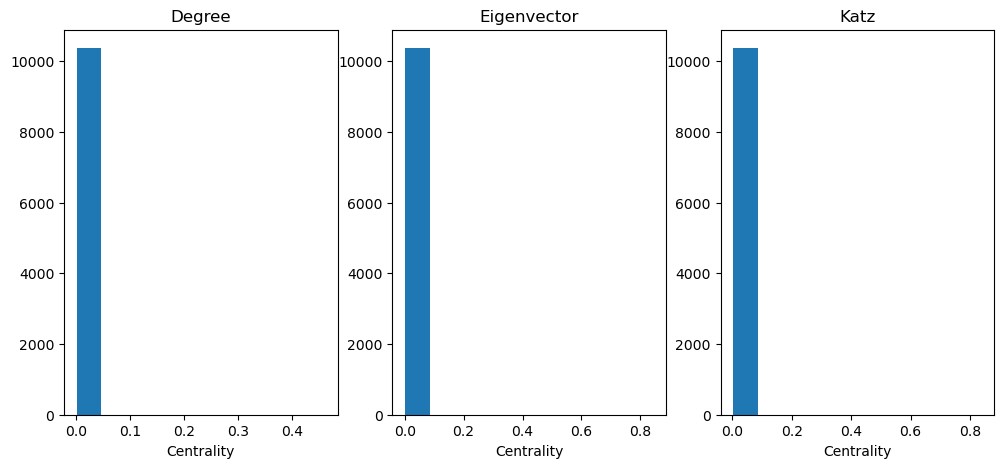

In [13]:
# plot histograms
plt.figure(figsize=(12, 5))
# Degree centrality
plt.subplot(1,3,1)
plt.hist(list(lDegCentrality.values()))
plt.title('Degree')
plt.xlabel('Centrality')
# eigenvector centrality
plt.subplot(1, 3, 2)
plt.hist(list(lEigenVectorCentrality.values()))
plt.title('Eigenvector')
plt.xlabel('Centrality')
# katz centrality
plt.subplot(1, 3, 3)
plt.hist(list(lKatzCentrality.values()))
plt.title('Katz')
plt.xlabel('Centrality')
plt.show()



In [14]:
#
# TODO: update the node attributes with centrality
#
# eigenvector centrality, stored in node attribute 'eigen'
for nodeId, cent in lEigenVectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(cent)

# katz centrality, stored in node attribute 'katz'
for nodeId, cent in lKatzCentrality.items():
    replyGraph.nodes[nodeId]['katz'] = float(cent)

# betweenness centrality, stored in node attribute 'betweenness'
for nodeId, cent in lBetweennessCentrality.items():
    replyGraph.nodes[nodeId]['betweenness'] = float(cent)   

# closeness centrality, stored in node attribute 'closeness'
for nodeId, cent in lClosenessCentrality.items():
    replyGraph.nodes[nodeId]['closeness'] = float(cent)


#
# TODO: write out graph to new file
#
nx.readwrite.write_graphml(replyGraph, 'mod' + sFileName, infer_numeric_types=True)


#
# TODO: compute the other SNA measures specified in the lab
#

#
# compute clustering
# the networkx code is within format(...)
#
print('Gloabl clustering coefficient/transitivity = {}'.format(nx.transitivity(replyGraph)))


#
# compute components
#
print('number of strongly connected components = {}'.format(nx.number_strongly_connected_components(replyGraph)))
print('number of weakly connected components = {}'.format(nx.number_weakly_connected_components(replyGraph)))

#
# compute bridges
#
print(list(nx.bridges(replyGraph.to_undirected())))

Gloabl clustering coefficient/transitivity = 0.14647971360381862
number of strongly connected components = 10378
number of weakly connected components = 1
[('Disney', '@GreatBeef97'), ('Disney', '@ti6091'), ('Disney', '@TeamRemForever'), ('Disney', '@Mr.joestarBrando'), ('Disney', '@airjelo5849'), ('Disney', '@brianangers6182'), ('Disney', '@Babyboy7672'), ('Disney', '@thatwouldbennyyy'), ('Disney', '@cristinamezquita9694'), ('Disney', '@jorgevmh'), ('Disney', '@elzadiasmarcelomarcelo4737'), ('Disney', '@anahisaldanagarcia3182'), ('Disney', '@dusicamitic3763'), ('Disney', '@johna6786'), ('Disney', '@zai-mam'), ('Disney', '@andyvanchhawng3056'), ('Disney', '@iabugueno'), ('Disney', '@JuanitoMerico-tp7fq'), ('Disney', '@justineves3588'), ('Disney', '@merohj'), ('Disney', '@youHeart787'), ('Disney', '@CarolinaHernandeztmnt'), ('Disney', '@kamilasouza712'), ('Disney', '@strwb.sara2313'), ('Disney', '@ItsUltraviolence'), ('Disney', '@marikk00'), ('Disney', '@alancristopher3539'), ('Disney',

In [15]:
# filename of graph to read in
sFilename = "modyoutube_maleficent_reply_graph.graphml"

In [16]:
def dictToSetFormat(dComms, maxCommNum):
    """
    Converts dictionary based community output (node -> community id) to list of sets (communities)
    @param dComms: dictionary based community representation
    @param maxCommNum: maximum number of communities
    @return: list of communities representation
    """

    # initialise
    com_list = [set() for x in range(maxCommNum)]
    # convert each (node : community id) pair to the required set format
    for (name, clusId) in dComms.items():
        com_list[clusId].add(name)

    return com_list

## Constructs communities

In [17]:
# read the reply graph in
from networkx.algorithms import community
import community as community_louvain

replyGraph = nx.readwrite.read_graphml(sFilename)

#
# compute communities
#

#
# TODO: Implement CPM
#

# k (clique size)
k = 3  # minimum value of a smallest complete graph
# placeholder.  Add the implementation to the right, but maintain the variable name.
lCpmComms = list(nx.algorithms.community.k_clique_communities(nx.to_undirected(replyGraph), k))
print(lCpmComms) # Print out the output of the communities by using the CPM algorithm

#
# TODO: Implement louvain
# louvain
# Use the Louvain algorithm from the python-louvain package
dLouvainComms = community_louvain.best_partition(nx.to_undirected(replyGraph))
print(dLouvainComms) # Print out the output of the communities by using the Louvain algorithm

# this code converts output of Louvain to the same format as CPM (makes it easier to have one consistent interface
louvanCommNum = max([y for (x,y) in dLouvainComms.items()]) + 1
lLouvainComms = dictToSetFormat(dLouvainComms, louvanCommNum)


#
# TODO: Write out cpm and Louvain values to node attributes of graph
#

# cpm labels, stored in node attribute 'cpmClusId'
for clusId, lComms in enumerate(lCpmComms):
    for nodeId in lComms:
        replyGraph.nodes[nodeId]['cpmClusId'] = clusId

# louvain labels, stored in node attribute 'louvain'
for clusId, lComms in enumerate(lLouvainComms):
    for nodeId in lComms:
        replyGraph.nodes[nodeId]['louvain'] = clusId


# Output modified graph with prefix mod2 to original file.
nx.readwrite.write_graphml(replyGraph, 'mod2' + sFilename, infer_numeric_types=True)



[frozenset({'@champestre', '@javier6973', '@johngrave5848', '@GloofiE', '@StealthDoctor', '@AsprosOfAzeroth', '@samuraijaco1', 'Jeremy Jahns'}), frozenset({'@chantalm9393', 'Lord Phoenix', '@hetereaux7873'}), frozenset({'@shortfusedkinda', '@stephaniemac4637', '@undeadpresident', '@reneeharbek7863', '@Surfing1709', '@kingblackthorn4195', '@rufousthefox9766', '@salenebrom6476', '@jayeshjadhav8863', '@dantejones2476', '@nikkigames2088', '@cimsosa', '@Viper_Cheri_Private', '@MakeupMan74', '@JesusLopez-wk6tt', '@agarnetsadvocate3586', '@GermanPrincess-pe8rl', '@talk7478', '@marinakapor1985', '@RadexNSW', '@IAMASELENATOR92', '@Liqliq888', '@7mandoblu', '@karaprince533', '@rosiesrose548', '@baptistecoissieu2955', '@rob20ist', '@aaliyahstark7948', '@DonnieBrasco-dy9yd', '@AntonioRodriguez97', '@lordcerrousV', '@KadenCooperArt', '@osmanyousif7849', '@florakettle', '@Nicole-ip6co', '@Nonamelol.', '@user-cb8bz6ez7x', '@ashtreesystem5265', '@lauriefaithprescott', '@psp785', '@gemma1874', '@untouc